## Module Imports

In [1]:
from treetime.utils import parse_dates
from treetime import TreeTime
from treetime import plot_vs_years

from Bio import Phylo

import random
import copy

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import cm
import matplotlib.ticker as ticker

import seaborn as sns

#from datetime import datetime
import datetime
import pandas as pd
from scipy import stats

## Setup input file paths

In [2]:
meta_path = "../Assembly_Modern/nextstrain/metadata_nextstrain_geocode_state.tsv"
tree_path = "../Assembly_Modern/iqtree/iqtree.core-filter0_bootstrap.treefile"
aln_path = "../Assembly_Modern/snippy_multi/snippy-core.full_CHROM.filter0.fasta"

## Constants and Variables

In [3]:
NUM_SAMPLE_REMOVE = 20
NUM_ITER = 1
NO_DATA_CHAR = "?"
VAL_DATE_REMOVE = [1894.00, 2019.00]
OUTGROUP = ["GCA_000323485.1_ASM32348v1_genomic",
            "GCA_000323845.1_ASM32384v1_genomic"]

slack = 1.0
coupling = 0.5
confidence = 0.9
# Offset for mutations: 0 will be 1-based
offset = 0
title = "Autocorrelated Relaxed Clock"
file_prefix = "autocorrelated-relaxed-clock"

random.seed(1753143)

## Parse the dates

In [4]:
dates = parse_dates(date_file=meta_path, date_col="BioSampleCollectionDate")


Attempting to parse dates...
	Using column 'strain' as name. This needs match the taxon names in the tree!!
	Using column 'BioSampleCollectionDate' as date.


## Parse the tree

In [5]:
tree = Phylo.read(tree_path, "newick")
tree_tip_names = [t.name for t in tree.get_terminals()]

## Tip-Dating: Randomly select the tip samples

In [6]:
dict_sample_remove = {}

for i in range(0,NUM_SAMPLE_REMOVE):
    
    # Retrieve tip name and val (date)
    tip = random.choice(list(dates.keys()))
    tip_val = dates[tip]
    
    # Check that it is a float (and not a list range)
    # And that it is actually in the input tree
    while type(tip_val) != type(0.1) or tip not in tree_tip_names:
        tip = random.choice(list(dates.keys()))
        tip_val = dates[tip] 
        
    dict_sample_remove[tip] = tip_val
    
    # Remove the metadata from the dates object
    dates[tip] = VAL_DATE_REMOVE

## Node-Dating: identify the internal nodes

In [7]:
## Black Death Node

## Root Node

## Treetime relaxed clock analysis

In [8]:
tt_relaxed = TreeTime(tree = tree_path,
                      aln = aln_path,
                      verbose = 4,
                      dates = dates)


0.00	-TreeAnc: set-up

66.46	-SequenceData: loaded alignment.

66.46	-SeqData: making compressed alignment...

180.89	-SequenceData: constructed compressed alignment...
200.53	--ClockTree: Setting precision to level 2

200.55	-ClockTree._assign_dates: assigned date contraints to 476 out of 476
      	 tips.


In [9]:
tt_relaxed.run(branch_length_mode = "joint",
               n_iqd=3,
               root=None,
               infer_gtr=True,
               resolve_polytomies=False,
               relaxed_clock={"slack":slack, "coupling":coupling},
               max_iter=3,
               Tc="skyline",
               use_covariation=True, 
               time_marginal=True, # Enable final round for error bar estimation,
               verbose=4,
              )


200.56	-TreeAnc.optimize_tree: sequences...

200.56	-TreeAnc.infer_ancestral_sequences with method: probabilistic, joint

200.56	WARNING: Previous versions of TreeTime (<0.7.0) RECONSTRUCTED sequences
      	of tips at positions with AMBIGUOUS bases. This resulted in unexpected
      	behavior is some cases and is no longer done by default. If you want to
      	replace those ambiguous sites with their most likely state, rerun with
      	`reconstruct_tip_states=True` or `--reconstruct-tip-states`.
200.56	--TreeAnc._ml_anc_joint: type of reconstruction: Joint
200.56	---TreeAnc._ml_anc_joint: Walking up the tree, computing likelihoods...
201.80	---TreeAnc._ml_anc_joint: Walking down the tree, computing maximum
      	   likelihood sequences...
201.84	---TreeAnc._ml_anc_joint: ...done
201.84	--TreeAnc.infer_gtr: counting mutations...
209.17	---TreeAnc.infer_gtr: counting mutations...done

209.17	-GTR: with alphabet: ['A', 'C', 'G', 'T', '-']
209.17	--GTR: ambiguous character: N
209.17	-

232.03	--optimized Tc to 0.000413
relaxed_clock {'slack': 1.0, 'coupling': 0.5}
232.19	--TreeTime.relaxed_clock: slack=1.000000, coupling=0.500000

232.20	-ClockTree: Maximum likelihood tree optimization with temporal
      	 constraints
232.20	--ClockTree.init_date_constraints...
232.20	---ClockTree.init_date_constraints: Initializing branch length
      	   interpolation objects...
238.49	--ClockTree.date2dist: Setting new molecular clock. rate=3.095e-08,
      	  R^2=0.0020
238.49	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
      	    excluding it from the optimization process. Date constraint will be
      	    ignored!
238.49	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
      	    excluding it from the optimization process. Date constraint will be
      	    ignored!
238.49	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
      	    excluding it from the optimization process. Date constraint will be
 

315.32	--ClockTree.date2dist: Setting new molecular clock. rate=3.095e-08,
      	  R^2=0.0020
315.32	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
      	    excluding it from the optimization process. Date constraint will be
      	    ignored!
315.32	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
      	    excluding it from the optimization process. Date constraint will be
      	    ignored!
315.32	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
      	    excluding it from the optimization process. Date constraint will be
      	    ignored!
315.32	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
      	    excluding it from the optimization process. Date constraint will be
      	    ignored!
315.32	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
      	    excluding it from the optimization process. Date constraint will be
      	    ignored!
315.32	---

'success'

## Compare actual with estimated

In [10]:
dict_sample_estimate = {}
list_ci_contain_sample_date = []

# Get the terminal nodes from the estimated relaxed clock model
for t in tt_relaxed.tree.get_terminals():
    if t.name in dict_sample_remove:
        conf = tt_relaxed.get_max_posterior_region(t, fraction=0.9)
        lower_conf = conf[0]
        upper_conf = conf[1]
        sample_date = dict_sample_remove[t.name]
        dict_sample_estimate[t.name] = {'sample_date': sample_date,
                                        'estimate_date': t.numdate,
                                        'lower_conf': lower_conf,
                                        'upper_conf': upper_conf
                                       }
        
        if lower_conf <= sample_date and upper_conf >= sample_date:
            list_ci_contain_sample_date.append(t.name)
        
perc_ci_contain_sample_date = (len(list_ci_contain_sample_date) / len(dict_sample_estimate)) * 100
  

#for sample in dict_sample_estimate:
#    print(sample)
#    print("\t", dict_sample_estimate[sample]['sample_date'])
#    print("\t", dict_sample_estimate[sample]['estimate_date'])
#    print("\t", dict_sample_estimate[sample]['lower_conf'])
#    print("\t", dict_sample_estimate[sample]['upper_conf'])


## Visualize differences

### Plot data

In [11]:
# Scatter plot of actual sampling dates

list_sample_name = list(dict_sample_estimate.keys())
list_sample_date = [dict_sample_estimate[sample]['sample_date'] for sample in dict_sample_estimate]
list_estimate_date = [dict_sample_estimate[sample]['estimate_date'] for sample in dict_sample_estimate]
list_lower_conf = [dict_sample_estimate[sample]['lower_conf'] for sample in dict_sample_estimate]
list_upper_conf = [dict_sample_estimate[sample]['upper_conf'] for sample in dict_sample_estimate]

# Lists for error bar calculations
list_lower_diff = []
list_upper_diff = []

zip_estimate_lower = zip(list_estimate_date, list_lower_conf)
for list1_i, list2_i in zip_estimate_lower:
    list_lower_diff.append(list1_i-list2_i)
    
zip_estimate_upper = zip(list_upper_conf, list_estimate_date)
for list1_i, list2_i in zip_estimate_upper:
    list_upper_diff.append(list1_i-list2_i)

    

### Plotting

/home/ktmeaton/miniconda3/envs/nextstrain-8.0.0/lib/python3.6/site-packages/matplotlib/collections.py:988: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


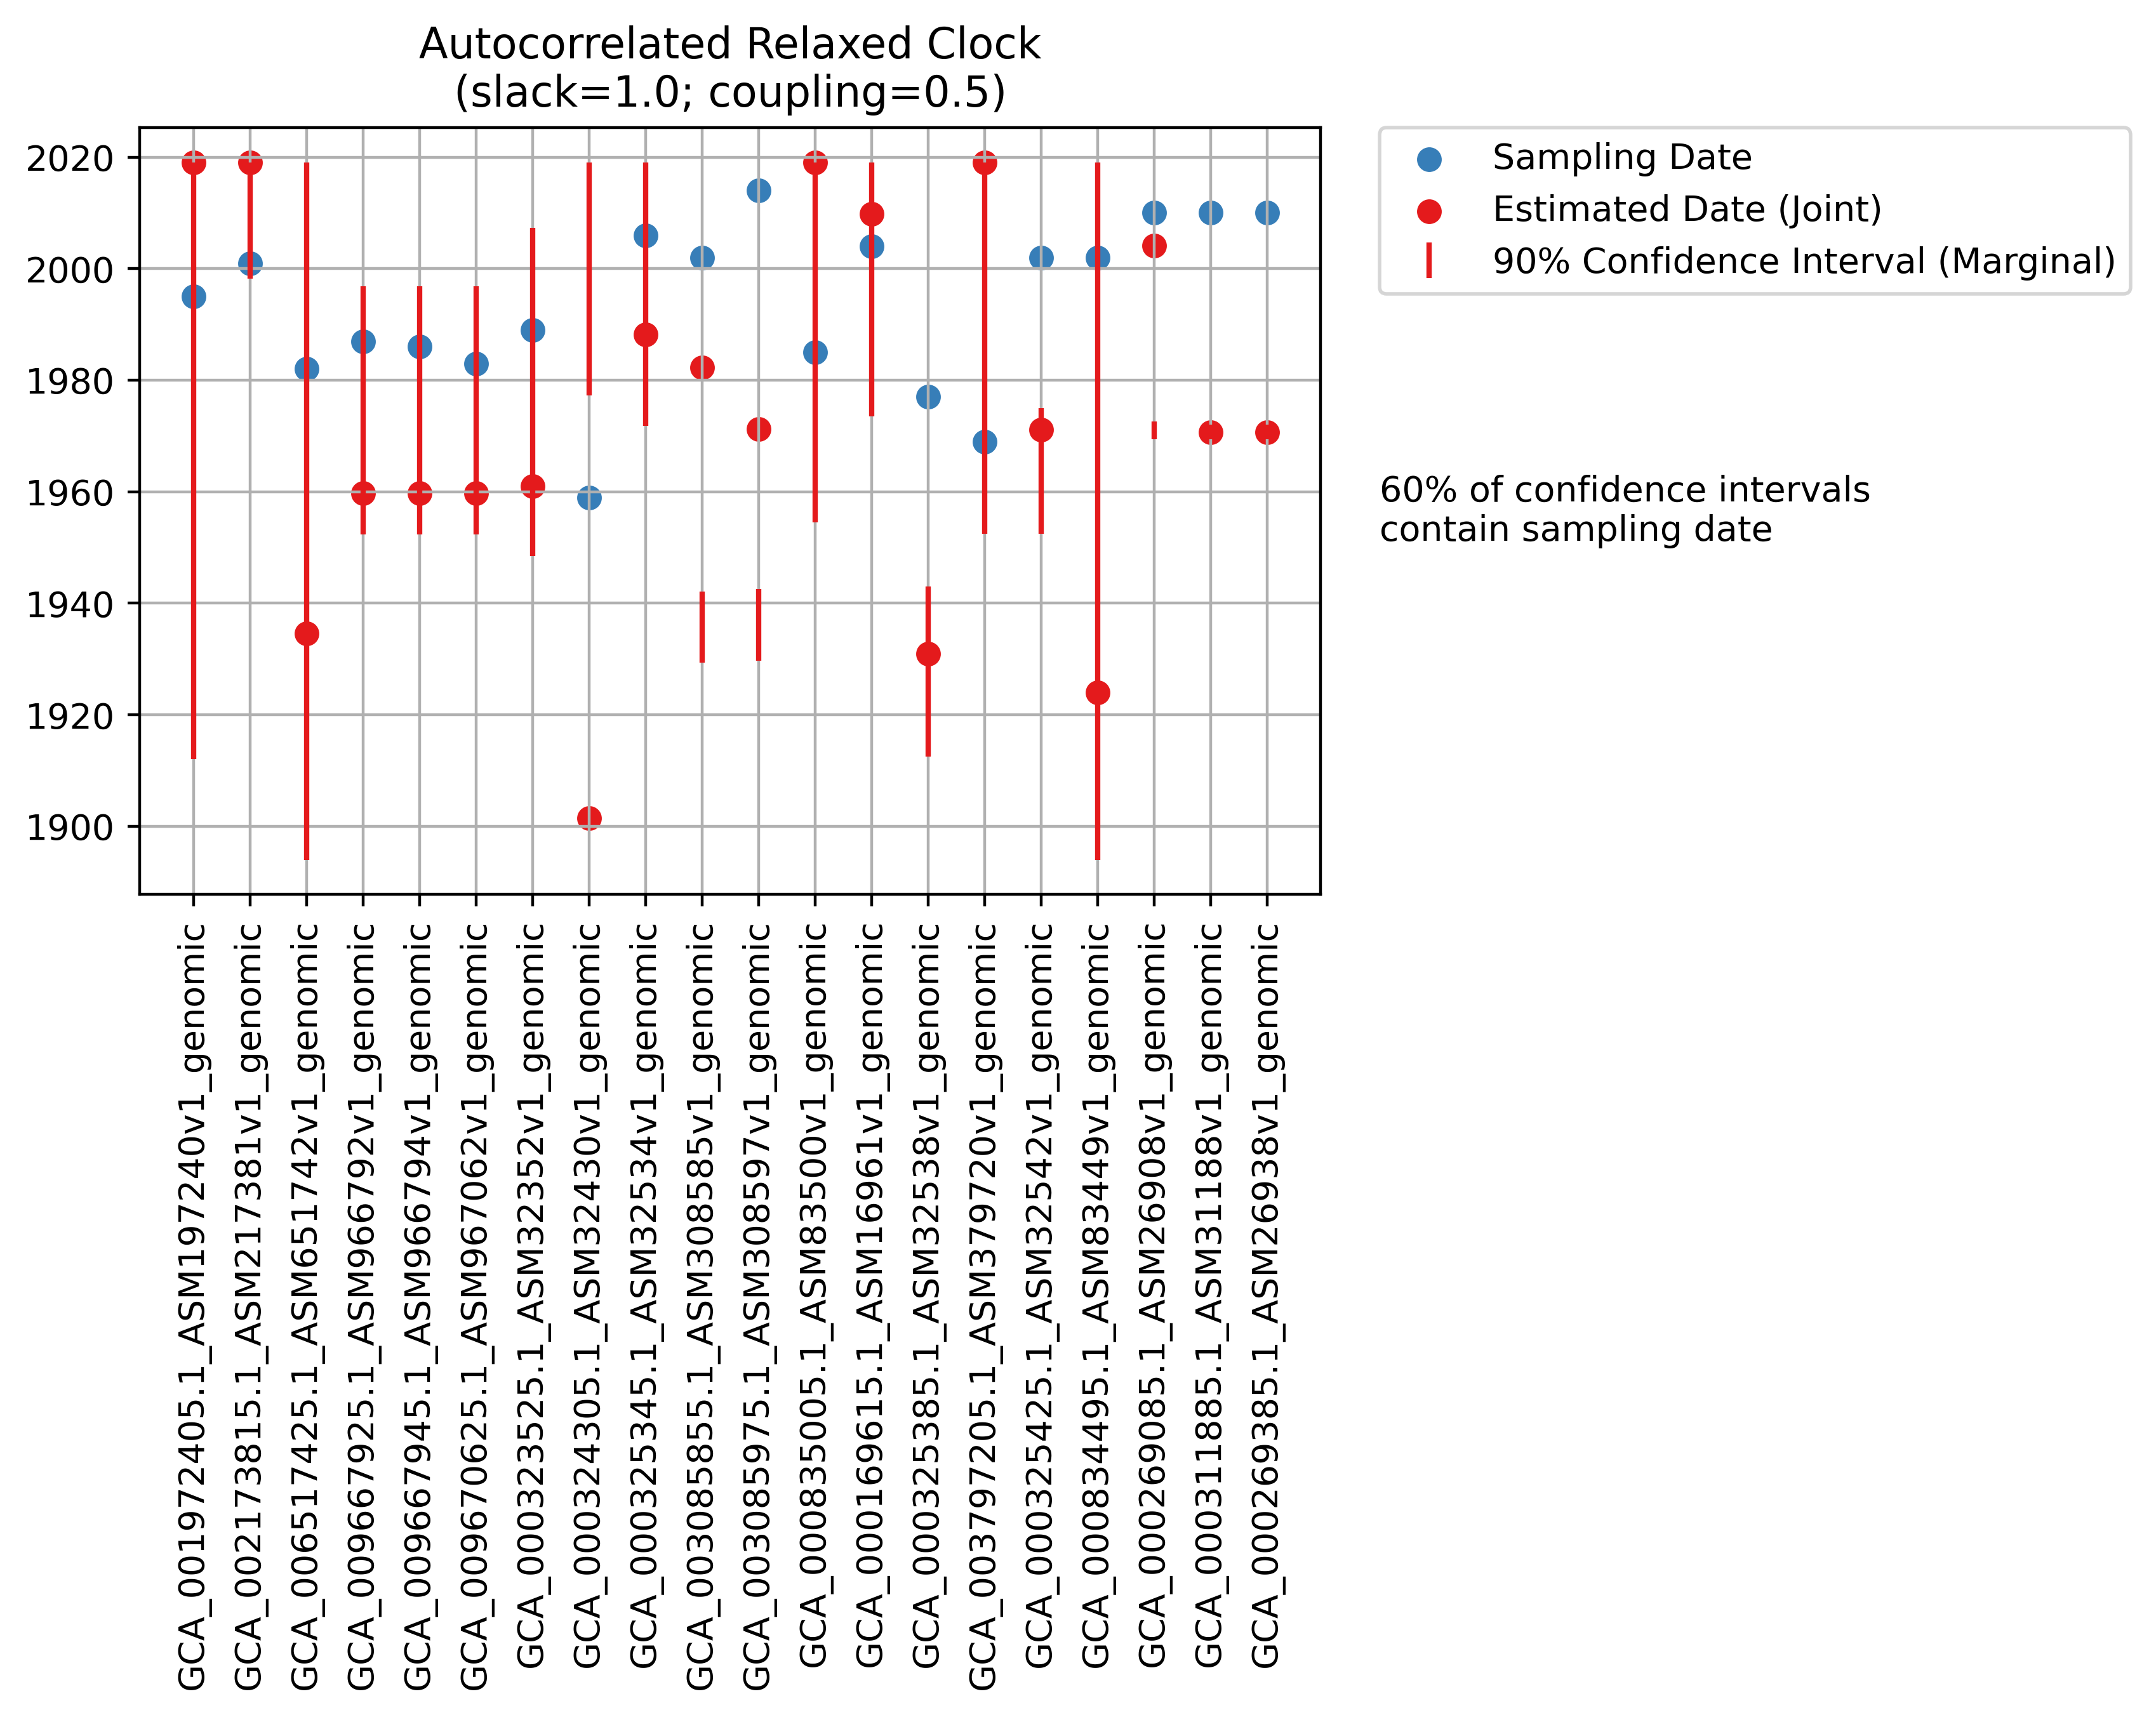

In [12]:
plt.figure(dpi=400)
ax = plt.subplot()
#print(fig)

# 90% Confidence Interval
plt.errorbar(
    x=list_sample_name,
    y=list_estimate_date,
    yerr=[list_lower_diff, list_upper_diff],
    linestyle='',
    c="#e41a1c",
    label="90% Confidence Interval (Marginal)",
)

# Sampling date scatter plot
scatter_sample = plt.scatter(x=list_sample_name, y=list_sample_date, c="#377eb8", label = "Sampling Date")

# Estimated date scatter plot
plt.scatter(x=list_sample_name, y=list_estimate_date, c="#e41a1c", label = "Estimated Date (Joint)", )

perc_string = "{0:.0f}% of confidence intervals \ncontain sampling date".format(perc_ci_contain_sample_date)
                                                                                
# Add text
plt.text(1.05, 0.5, 
         perc_string, 
         horizontalalignment='left', 
         verticalalignment='center', 
         transform=ax.transAxes)

# Formatting
plt.xticks(rotation=90)
plt.grid(True)

# Place a legend to the right of this smaller subplot.
legend1 = plt.legend(handles=scatter_sample.legend_elements()[0],
                     labels= [""],
                     bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


#plt.gca().add_artist(legend1)
# Title
plt.title("{}\n(slack={:.1f}; coupling={:.1f})".format(title, slack, coupling))
plt.savefig("{}_leave-one-out.png".format(file_prefix), dpi=400, bbox_inches = "tight")

## Plot Trees

In [13]:
vmin, vmax = 0.5, 1.5 # color branches according to the rate deviation

for n in tt_relaxed.tree.find_clades():
    if n.up:
        n.color = [int(x*255) for x in cm.cool((min(max(vmin, n.branch_length_interpolator.gamma),vmax)-vmin)/(vmax-vmin))[:3]]
    else:
        n.color = [200,200,200]


<Figure size 2400x1600 with 0 Axes>

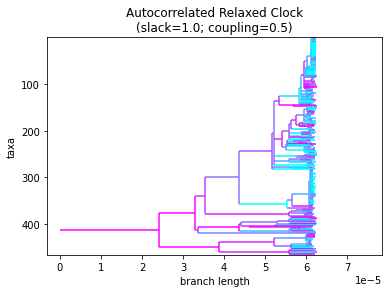

In [14]:
# draw trees inferred with the relaxed model
plt.figure(dpi=400)
fig = plt.figure()
ax = plt.subplot()

# Remove the outgroup
nodes_find_root = ["GCA_000323845.1_ASM32384v1_genomic","GCA_000323485.1_ASM32348v1_genomic","GCA_001972405.1_ASM197240v1_genomic"]

subtree = tt_relaxed.tree.common_ancestor(nodes_find_root)
for c in subtree.clades:
    if not c.is_terminal():
        subtree = c
        break

# Draw tree 
subtree.ladderize(reverse=True) # Flip upside down
Phylo.draw(subtree, axes=ax, 
           show_confidence=False, 
           label_func = lambda x:'', 
           do_show=False)

ax.set_title("{}\n(slack={:.1f}; coupling={:.1f})".format(title, slack, coupling))
plt.savefig("{}_rate-variation.png".format(file_prefix), dpi=400, bbox_inches = "tight")

## Skyline

<Figure size 2400x1600 with 0 Axes>

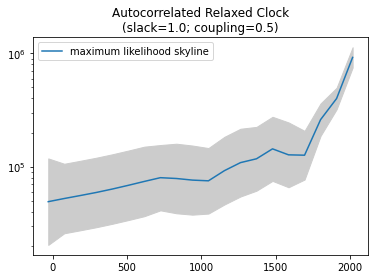

In [15]:
#plt.figure(dpi=400)
#x = wrappers.print_save_plot_skyline(tt_relaxed, n_std=2.0, screen=False)
skyline, conf = tt_relaxed.merger_model.skyline_inferred(gen=50, confidence=2)

plt.figure(dpi=400)
fig = plt.figure()
ax = plt.subplot()

plt.fill_between(skyline.x, conf[0], conf[1], color=(0.8, 0.8, 0.8))
plt.plot(skyline.x, skyline.y, label='maximum likelihood skyline')
plt.yscale('log')
plt.legend()
plt.ticklabel_format(axis='x',useOffset=False)

ax.set_title("{}\n(slack={:.1f}; coupling={:.1f})".format(title, slack, coupling))
plt.savefig("{}_skyline.png".format(file_prefix), dpi=400)

## Plot Root To Tip: v1

<Figure size 2400x1600 with 0 Axes>

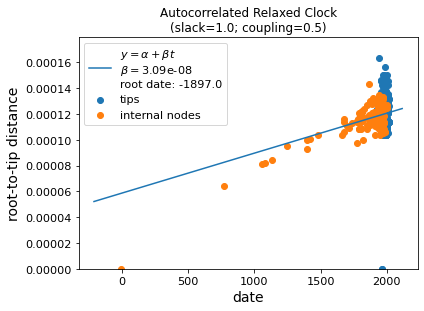

<Figure size 2400x1600 with 0 Axes>

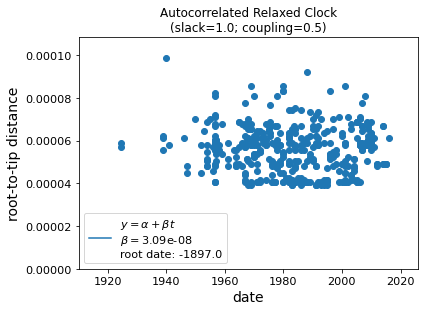

In [16]:
tt_relaxed_no_outgroup = copy.deepcopy(tt_relaxed)

for t in tt_relaxed_no_outgroup.tree.get_terminals():
    if t.name in OUTGROUP:
        # Prune outgroup terminals
        tt_relaxed_no_outgroup.tree.prune(t)

# With outgroup and internal nodes (root and line makes graphical sense)
plt.figure(dpi=400)
fig = plt.figure()
ax = plt.subplot()
tt_relaxed.plot_root_to_tip(add_internal=True,ax=ax)
ax.set_title("{}\n(slack={:.1f}; coupling={:.1f})".format(title, slack, coupling))
plt.savefig("{}_rtt-internal.png".format(file_prefix), dpi=400, bbox_inches = "tight")

# No outgorup and only tips
plt.figure(dpi=400)
fig = plt.figure()
ax = plt.subplot()
tt_relaxed_no_outgroup.plot_root_to_tip(ax=ax)
ax.set_title("{}\n(slack={:.1f}; coupling={:.1f})".format(title, slack, coupling))
plt.savefig("{}_rtt-no-outgroup.png".format(file_prefix), dpi=400, bbox_inches = "tight")

## Plot Root To Tip: v2

### Setup Data Frame

0.07131612593951613


'\nax.yaxis.set_major_locator(ticker.MultipleLocator(0.00001))\n# plot legend\nax.legend()\n\nax.set_title("{}\n(slack={:.1f}; coupling={:.1f})".format(title, slack, coupling))\nplt.savefig("{}_rtt-2.png".format(file_prefix), dpi=400, bbox_inches = "tight")\n'

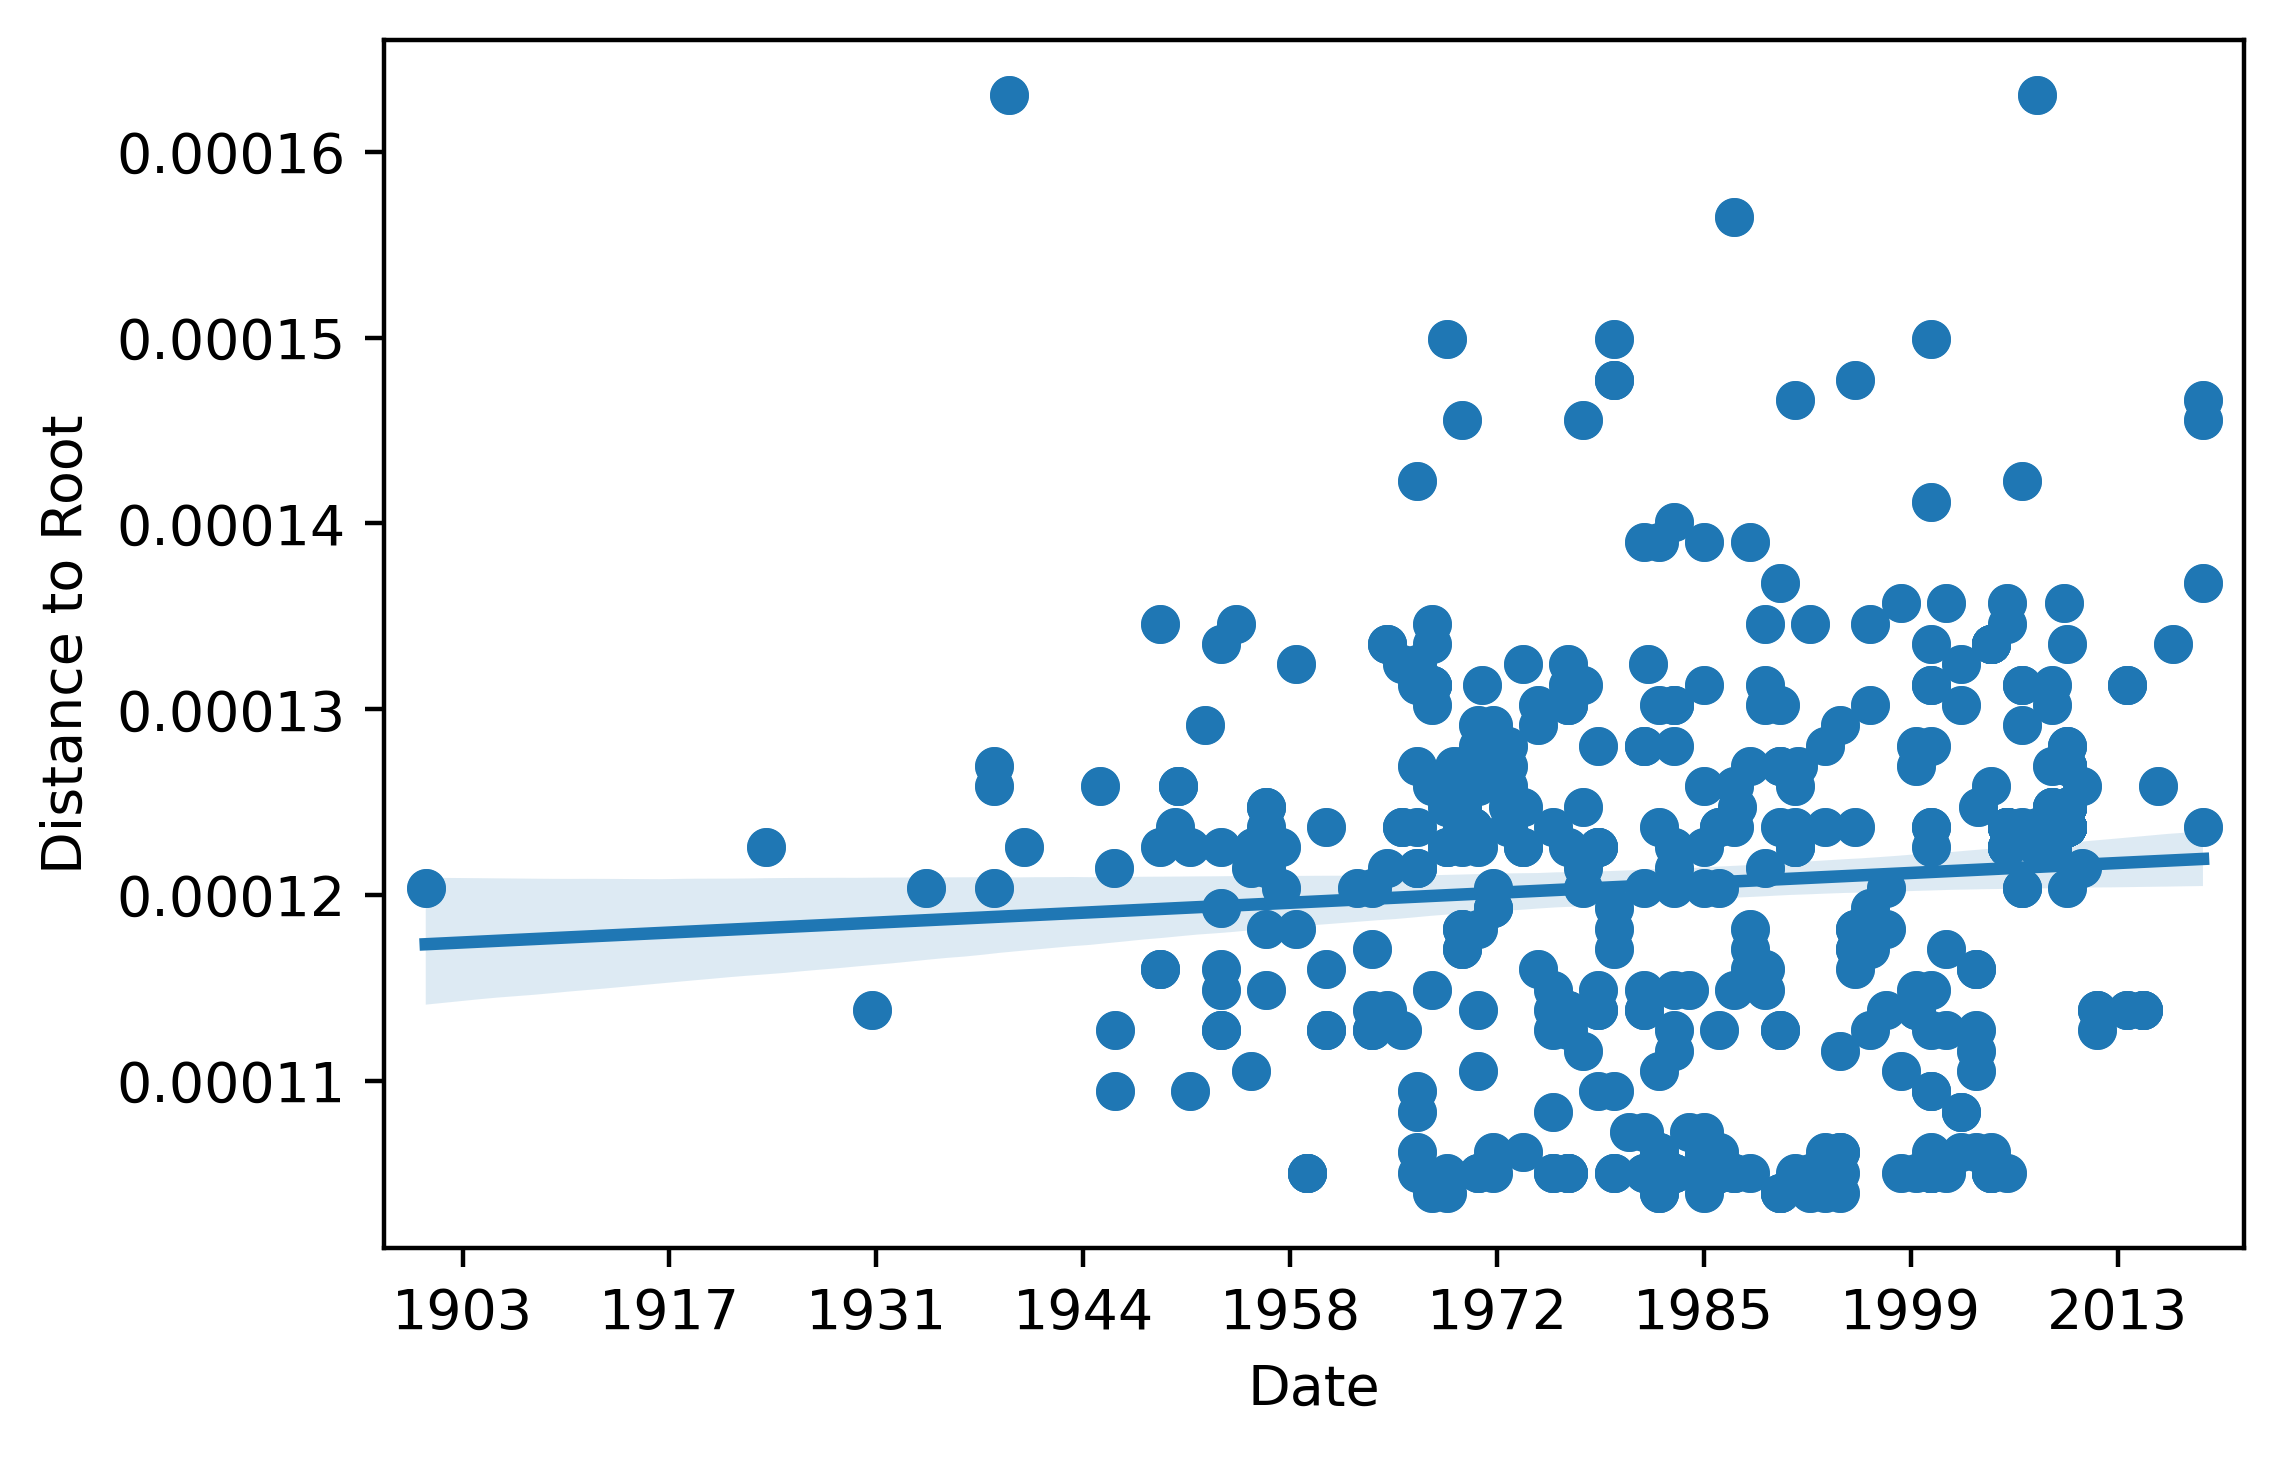

In [17]:
full_dist2root = []
full_date = []

# Plot the timetree
for n in tt_relaxed_no_outgroup.tree.get_terminals():
    full_dist2root.append(n.dist2root)
    full_date.append(n.date)

df = pd.DataFrame({
                  "dist2root" : full_dist2root,
                  "date": full_date
                 })


df['date_ordinal'] = pd.to_datetime(df['date']).apply(lambda date: date.toordinal())

plt.figure(dpi=400)
points = plt.scatter(x=df['date_ordinal'], 
                    y=df['dist2root'])

slope, intercept, r_value, p_value, std_err = stats.linregress(df['date_ordinal'],df['dist2root'])
print(r_value)
ax = sns.regplot(x="date_ordinal",
                       y="dist2root",
                       data=df,
                       ci=90,
                       line_kws={'label':"r2={0:.2f}".format(r_value)})
                       #line_kws={'label':"y={0:.2f}x+{1:.2f}".format(slope,intercept)})

ax.set_xlim(df['date_ordinal'].min() - 1000, df['date_ordinal'].max() + 1000)
ax.set_xlabel('Date')
ax.set_ylabel('Distance to Root')

new_labels = [datetime.date.fromordinal(int(item)).year for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
"""
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.00001))
# plot legend
ax.legend()

ax.set_title("{}\n(slack={:.1f}; coupling={:.1f})".format(title, slack, coupling))
plt.savefig("{}_rtt-2.png".format(file_prefix), dpi=400, bbox_inches = "tight")
"""

## Add Node Comments

In [18]:
for n in tt_relaxed.tree.find_clades():
    # Add mutations comment
    if n.mutations:
        mut_comment = 'mutations="' + ','.join([a+str(pos + offset)+d for (a,pos, d) in n.mutations
                                                              if tt_relaxed.gtr.ambiguous not in [a,d]])+'"'
        if n.comment:
            n.comment = ",".join([n.comment, mut_comment])
        else:
            n.comment = "&" + mut_comment
    # Add date comment
    if n.numdate:
        date_comment = 'date={:.2f}'.format(n.numdate)
        if n.comment:
            n.comment = ",".join([n.comment, date_comment])
        else:
            n.comment = "&" + date_comment

## Export Stats

In [19]:
# Dates Confidence File Header
fh_dates = open("{}_dates.tsv".format(file_prefix), 'w', encoding='utf-8')
fh_dates.write('#Lower and upper bound delineate the 90% max posterior region\n')
fh_dates.write('#node\tdate\tnumeric date\tlower bound\tupper bound\n')

for n in tt_relaxed.tree.find_clades():
    if n.bad_branch:
        fh_dates.write('%s\t--\t--\t--\t--\n'%(n.name))
    else:
        conf = tt_relaxed.get_max_posterior_region(n, fraction=confidence)       
#--------------

# Substition File Header
fh_rates = open("{}_rates.tsv".format(file_prefix), 'w', encoding='utf-8')
fh_rates.write("#node\tclock_length\tmutation_length\trate\tfold_change\n")

for n in tt_relaxed.tree.find_clades(order="preorder"):
    if n==tt_relaxed.tree.root:
        continue
    g = n.branch_length_interpolator.gamma
    fh_rates.write("%s\t%1.3e\t%1.3e\t%1.3e\t%1.2f\n"%(n.name, n.clock_length, n.mutation_length, tt_relaxed.date2dist.clock_rate*g, g))

## Write Output Trees

In [ ]:
# Figtree compatible timetrees
tt_relaxed_plain = copy.deepcopy(tt_relaxed)
# Divergence tree
tt_relaxed_div = copy.deepcopy(tt_relaxed)

# Write timetrees
Phylo.write(tt_relaxed.tree, open("{}_timetree.nexus".format(file_prefix), "w"), "nexus", format_branch_length='%1.10f')
Phylo.write(tt_relaxed.tree, open("{}_timetree.newick".format(file_prefix), "w"), "newick", format_branch_length='%1.10f')
#----------------

# Figtree compatible timetrees
for c in tt_relaxed_plain.tree.find_clades():
    # Make sure all branches have length (not None)
    if c.branch_length is None:
        c.branch_length = 0
    # Remove internal node names
    if not c.is_terminal():
        c.name = None
        
Phylo.write(tt_relaxed_plain.tree, open("{}_timetree-plain.newick".format(file_prefix), "w"), "newick", format_branch_length='%1.10f')     
Phylo.write(tt_relaxed_plain.tree, open("{}_timetree-plain.nexus".format(file_prefix), "w"), "nexus", format_branch_length='%1.10f')     
#------------------

# Write divergence trees
for c in tt_relaxed_div.tree.find_clades():
    c.branch_length = n.mutation_length

Phylo.write(tt_relaxed_div.tree, open("{}_divtree.nexus".format(file_prefix), "w"), 'nexus', format_branch_length='%1.10f')
Phylo.write(tt_relaxed_div.tree, open("{}_divtree.newick".format(file_prefix), "w"), 'newick', format_branch_length='%1.10f')
#-------------------

# Figtree compatible divergence trees
for c in tt_relaxed_div.tree.find_clades():
    # Make sure all branches have length (not None)
    if c.branch_length is None:
        c.branch_length = 0
    # Remove internal node names
    if not c.is_terminal():
        c.name = None

Phylo.write(tt_relaxed_div.tree, open("{}_divtree-plain.newick".format(file_prefix), "w"), "newick", format_branch_length='%1.10f')    
Phylo.write(tt_relaxed_div.tree, open("{}_divtree-plain.nexus".format(file_prefix), "w"), "nexus", format_branch_length='%1.10f')    

## Plot Output Trees

1671.97	--ClockTree.branch_length_to_years: setting node positions in units of
       	  years


<Figure size 2400x1600 with 0 Axes>

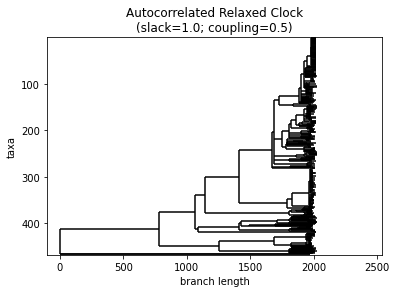

<Figure size 432x288 with 0 Axes>

In [56]:
# Reset color to black
for n in tt_relaxed.tree.find_clades():
    n.color = [0,0,0]

plt.figure(dpi=400)
fig = plt.figure()
ax = plt.subplot()
ax.set_title("{}\n(slack={:.1f}; coupling={:.1f})".format(title, slack, coupling))
tt_relaxed.tree.ladderize(reverse=True) # Flip upside down
plot_vs_years(tt_relaxed, show_confidence=False, confidence=confidence, ax=ax)
plt.savefig("{}_timetree.png".format(file_prefix), dpi=400, bbox_inches = "tight")